# **Exploring HuggingFace Datasets**

In [1]:
from __future__ import annotations
from operator import itemgetter
from itertools import zip_longest
import fastcore.all as fc
import pickle, gzip, math, os, time, shutil, logging, os

from pathlib import Path
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
from torch import tensor, nn, optim
from torch.utils.data import DataLoader, default_collate
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from fastcore.test import  test_close
from datasets import load_dataset, load_dataset_builder

# Configs
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'
torch.set_printoptions(precision=3, linewidth=125, sci_mode=False)
np.set_printoptions(precision=3, linewidth=125)

In [2]:
logging.disable(logging.WARNING)

## **Accessing HuggingFace Datasets**

Alongside the hub and spaces, HuggingFace also has a very large repository of datasets which can be used for experimentation, practice or portfolio building.

In [3]:
name  = "fashion_mnist"
ds_builder = load_dataset_builder(name)
print(ds_builder.info.description) # This provides handy meta data for the dataset.

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of
60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image,
associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in
replacement for the original MNIST dataset for benchmarking machine learning algorithms.
It shares the same image size and structure of training and testing splits.



In [4]:
# We can dive deeper into the dataset features
ds_builder.info.features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [5]:
# We can also get the training and test splits
ds_builder.info.splits

{'train': SplitInfo(name='train', num_bytes=31296607, num_examples=60000, shard_lengths=None, dataset_name='fashion_mnist'),
 'test': SplitInfo(name='test', num_bytes=5233810, num_examples=10000, shard_lengths=None, dataset_name='fashion_mnist')}

In [6]:
# Once we're sure about the dataset in question, we can download them directly into a local object.
dsd = load_dataset(name)
dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

The fact that we're getting everything organized and split by training and test sets, plus feature labels, is really cool. This functionality is similar to what was done in the previous notebook i.e. [06_mini_batch_training](https://github.com/bachaudhry/FastAI-22-23/blob/main/course_part_2/05_minibatch_training.ipynb).

The key difference is that we're now working with dictionaries instead of tuples.

In [7]:
train, test = dsd['train'], dsd['test']
train[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

In [8]:
# Storing labels as variables to reduce repetition.
#x, y = 'image', 'label'
# This is much cleaner.
x, y = ds_builder.info.features
img = train[0][x]
img

In [9]:
# Grabbing the first 5 images and labels
xb = train[:5][x]
yb = train[:5][y]
yb

[9, 0, 0, 3, 0]

In [10]:
# Get class mappings from features
feat = train.features[y]
feat

ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)

In [11]:
# Direct class mappings on samples
feat.int2str(yb), train['label'][:5]

(['Ankle boot',
  'T - shirt / top',
  'T - shirt / top',
  'Dress',
  'T - shirt / top'],
 [9, 0, 0, 3, 0])

Now that we have our datasets, moving onto model training should be pretty straight forward.

Let's review the `collate function` from `05_minibatch_training` which will be slighlty different as compared to the previous NB. This approach allows us to reduce the amount of abstraction which was typically necessary for previous iterations dataloaders. So `collate_fn()` will:

1. Loop through each batch.
2. Convert items to Tensors.
3. Stack them up.

...all in one go.

In [12]:
def collate_fn(b):
    # This will return a dictionary instead of a tuple in order to align with HuggingFace's approach.
    return {x: torch.stack([TF.to_tensor(o[x]) for o in b]),
            y: tensor([o[y] for o in b])} # This stacks on integers so we don't need to call torch.stack() explicitly

In [13]:
# Creating DataLoader
dl = DataLoader(train, collate_fn=collate_fn, batch_size=16)
b = next(iter(dl))
# The batch has 16 images with each image being 28x28
b[x].shape, b[y]

(torch.Size([16, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

HuggingFace also allows us to move away from collation functions for simplified and flexible custom functionality. 

In [14]:
def transforms(b):
    # Within each batch, replace the PIL images with tensors
    b[x] = [TF.to_tensor(o) for o in b[x]]
    return b

HuggingFace's `with_transform()` applies the transformation on the fly when `__getitem__()` is called.

In [15]:
# Using with_transform() applies the custom transformation
tds = train.with_transform(transforms)
dl = DataLoader(tds, batch_size=16) # Now we don't need a collate function
b = next(iter(dl))

b[x].shape, b[y]

(torch.Size([16, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

However, as Jeremy pointed out, having `transforms()` return an object requires extra code that can be avoided. We can write a custom transformation function which runs inplace and can be stored as a callable object.

In [16]:
# Creating transformation which can run inplace
def _transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [17]:
# Now we can create an additional function which runs the inplace operation
def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

In [18]:
# Calling the inplace transformation using our "function generating function"
# func     = _func    (_func)
transformi = inplace(_transformi)

In [19]:
# Rerunning with_transform() which returns the same result as the more verbose version above.
r = train.with_transform(transformi)[0]
r[x].shape, r[y]

(torch.Size([784]), 9)

The fun part is that what we just implemented above i.e. using `transformi = inplace(_transformi)` where a function generates other functions, mirrors the functionality of Python **decorators**.

In [20]:
# Calling inplace as a decorator and redefining the transform function.
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [21]:
# Our results will be the same as before
tdsf = train.with_transform(transformi)
r = tdsf[0]

r[x].shape, r[y]

(torch.Size([784]), 9)

Moving on, we can also play around with the dynamic and highly flexible design of Python to add to the functionality of libraries like HuggingFace.

The `itemgetter()` function is a great example of this concept at work.

In [22]:
d = dict(a=1, b=2, c=3)
# Apply itemgetter to the dict above
ig = itemgetter('a', 'c')
ig(d)

(1, 3)

In [23]:
# This can be extended to classes as well.
class D:
    def __getitem__(self, k): return 1 if k=='a' else 2 if k=='b' else 3

In [24]:
d = D()
ig(d)

(1, 3)

In [25]:
list(tdsf.features)

['image', 'label']

...continuing on the thread of flexibility, we can also experiment with Python's `default_collate()` function, which works exactly as the name implies.

In [26]:
batch = dict(a=[1], b=[2]), dict(a=[3], b=[4])
batch

({'a': [1], 'b': [2]}, {'a': [3], 'b': [4]})

Let's see what the documentation for `default_collate` says.

In [27]:
default_collate?

Signature: default_collate(batch)
Docstring:
Take in a batch of data and put the elements within the batch into a tensor with an additional outer dimension - batch size.

The exact output type can be a :class:`torch.Tensor`, a `Sequence` of :class:`torch.Tensor`, a
Collection of :class:`torch.Tensor`, or left unchanged, depending on the input type.
This is used as the default function for collation when
`batch_size` or `batch_sampler` is defined in :class:`~torch.utils.data.DataLoader`.

Here is the general input type (based on the type of the element within the batch) to output type mapping:

    * :class:`torch.Tensor` -> :class:`torch.Tensor` (with an added outer dimension batch size)
    * NumPy Arrays -> :class:`torch.Tensor`
    * `float` -> :class:`torch.Tensor`
    * `int` -> :class:`torch.Tensor`
    * `str` -> `str` (unchanged)
    * `bytes` -> `bytes` (unchanged)
    * `Mapping[K, V_i]` -> `Mapping[K, default_collate([V_1, V_2, ...])]`
    * `NamedTuple[V1_i, V2_i, ...]` -> 

In [28]:
default_collate(batch)

{'a': [tensor([1, 3])], 'b': [tensor([2, 4])]}

We can now create a function called `collate_dict()` which will take a dataset and create an `itemgetter()` function for the features i.e. images and labels. This function will then call `default_collate()` in place to collate these items for us.

In [29]:
def collate_dict(ds):
    # Takes a dictionary and collates it into a tuple.
    get = itemgetter(*ds.features)
    def _f(b): return get(default_collate(b))
    return _f

In [30]:
# Calling collate_dict() inside the collate_fn for the DataLoader
dlf = DataLoader(tdsf, batch_size=4, collate_fn=collate_dict(tdsf))
xb, yb = next(iter(dlf))
xb.shape, yb

(torch.Size([4, 784]), tensor([9, 0, 0, 3]))

This sort of flexibility allows us to easily move between HuggingFace and PyTorch, where data objects are usually stored as dictionaries for the prior and tuples in the case of the latter.|

## **Visualizing the Dataset**

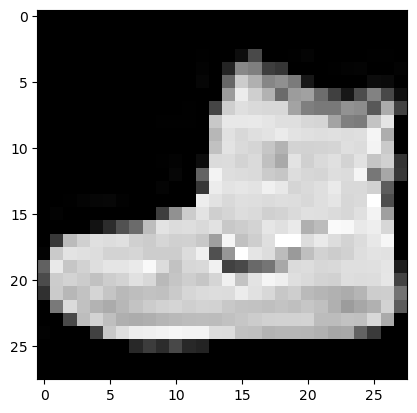

In [32]:
# Plot an image from a batch
b = next(iter(dl))
xb = b['image']
img = xb[0]
plt.imshow(img[0]);

Let's create a function which handles our plotting, cleans up the axes and can take additional arguments based on different use-cases.

In [33]:
fc.delegates??

Signature: fc.delegates(to: function = None, keep=False, but: list = None)
Source:   
def delegates(to:FunctionType=None, # Delegatee
              keep=False, # Keep `kwargs` in decorated function?
              but:list=None): # Exclude these parameters from signature
    "Decorator: replace `**kwargs` in signature with params from `to`"
    if but is None: but = []
    def _f(f):
        if to is None: to_f,from_f = f.__base__.__init__,f.__init__
        else:          to_f,from_f = to.__init__ if isinstance(to,type) else to,f
        from_f = getattr(from_f,'__func__',from_f)
        to_f = getattr(to_f,'__func__',to_f)
        if hasattr(from_f,'__delwrap__'): return f
        sig = inspect.signature(from_f)
        sigd = dict(sig.parameters)
        k = sigd.pop('kwargs')
        s2 = {k:v.replace(kind=inspect.Parameter.KEYWORD_ONLY) for k,v in inspect.signature(to_f).parameters.items()
              if v.default != inspect.Parameter.empty and k not in sigd and k not in but}
   

In [35]:
@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, noframe=True, **kwargs):
    "Show PIL or PyTorch image on `ax`."
    # Detach tensor from the computational graph and move it to the CPU.
    if fc.hasattrs(im, ('cpu', 'permute', 'detach')):
        im = im.detach().cpu() 
        # If tensor has 3 dims and the first dim(usually the channel) is less than 5, 
        # (suggesting it could be an image with channels first), then permute the dim. to 
        # make the channel the last dimension(H, W, C).
        if len(im.shape)==3 and im.shape[0]<5: im = im.permute(1, 2, 0) 
    elif not isinstance(im, np.ndarray): im = np.array(im)    
    # If the last dim of `im` has size 1 (single channel img), squeeze out the dim.
    if im.shape[-1]==1: im = im[...,0]                                 
    if ax is None: _, ax = plt.subplots(figsize=figsize)
    # Plot img with any additional kwargs
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    if noframe: ax.axis('off')
    return ax 

In [36]:
# We can get additional information about the functions arguments
# The @fc.delegates decorator appends additional info about the **kwargs
help(show_image)

Help on function show_image in module __main__:

show_image(im, ax=None, figsize=None, title=None, noframe=True, *, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None)
    Show PIL or PyTorch image on `ax`.



In [40]:
help??

Signature:   help(*args, **kwds)
Type:        _Helper
String form: Type help() for interactive help, or help(object) for help about object.
Namespace:   Python builtin
File:        ~/miniforge3/lib/python3.10/_sitebuiltins.py
Source:     
class _Helper(object):
    """Define the builtin 'help'.

    This is a wrapper around pydoc.help that provides a helpful message
    when 'help' is typed at the Python interactive prompt.

    Calling help() at the Python prompt starts an interactive help session.
    Calling help(thing) prints help for the python object 'thing'.
    """

    def __repr__(self):
        return "Type help() for interactive help, " \
               "or help(object) for help about object."
    def __call__(self, *args, **kwds):
        import pydoc
        return pydoc.help(*args, **kwds)

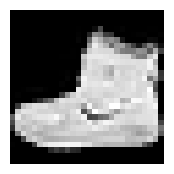

In [37]:
show_image(img, figsize=(2, 2));

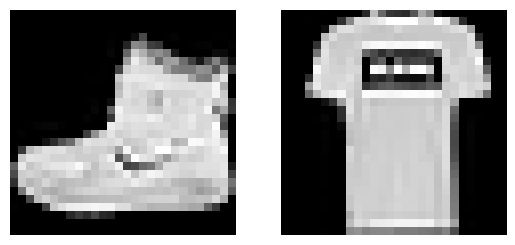

In [38]:
# Adding imgs
fig, axs = plt.subplots(1, 2)
show_image(img, axs[0])
show_image(xb[1], axs[1]);

Adding additional functionality on `subplots()`.

In [41]:
@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows:    int=1,       # Number of rows in the returned axes grid
    ncols:    int=1,       # Number of columsn in returned axes grid
    figsize:  tuple=None,  # Width, height in inches of the returned figure
    imsize:   int=3,       # Size (in inches) of images that will be displayed in the returned figure
    suptitle: str=None,    # Title to be set to returned figure
    **kwargs
): # fig and axes
    "A figure and set of subplots to display images of `imsize` inches"
    if figsize is None: figsize=(ncols*imsize, nrows*imsize)
    fig, ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if suptitle is not None: fig.suptitle(suptitle)
    if nrows*ncols==1: ax = np.array([ax])
    return fig, ax

All this additional functionality, with the docstrings, can have its documentation generated by **nbdev**. Which is super handy!!!

In [42]:
from nbdev.showdoc import show_doc

show_doc(subplots)

---

### subplots

>      subplots (nrows:int=1, ncols:int=1, figsize:tuple=None, imsize:int=3,
>                suptitle:str=None,
>                sharex:"bool|Literal['none','all','row','col']"=False,
>                sharey:"bool|Literal['none','all','row','col']"=False,
>                squeeze:bool=True, width_ratios:Sequence[float]|None=None,
>                height_ratios:Sequence[float]|None=None,
>                subplot_kw:dict[str,Any]|None=None,
>                gridspec_kw:dict[str,Any]|None=None, **kwargs)

*A figure and set of subplots to display images of `imsize` inches*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| nrows | int | 1 | Number of rows in the returned axes grid |
| ncols | int | 1 | Number of columsn in returned axes grid |
| figsize | tuple | None | Width, height in inches of the returned figure |
| imsize | int | 3 | Size (in inches) of images that will be displayed in the returned figure |
| suptitle | str | None | Title to be set to returned figure |
| sharex | bool \| Literal['none', 'all', 'row', 'col'] | False |  |
| sharey | bool \| Literal['none', 'all', 'row', 'col'] | False |  |
| squeeze | bool | True |  |
| width_ratios | Sequence[float] \| None | None |  |
| height_ratios | Sequence[float] \| None | None |  |
| subplot_kw | dict[str, Any] \| None | None |  |
| gridspec_kw | dict[str, Any] \| None | None |  |
| kwargs |  |  |  |

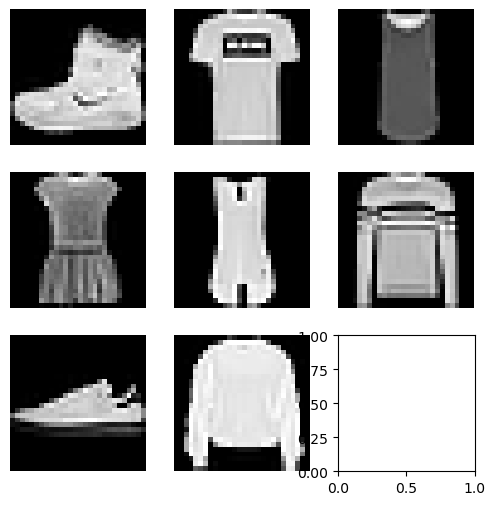

In [43]:
# Plotting a grid
fig, axs = subplots(3, 3, imsize=2)
imgs = xb[:8]
# flat is used to iterate over arrays
for ax, img in zip(axs.flat, imgs): show_image(img, ax)

 The grid doesn't look very...presentable. We can improve the functionality of the plotting functions even further.

In [44]:
@fc.delegates(subplots)
def get_grid(
    n:      int,        # Number of axes
    nrows:  int=None,   # Number of rows, defaulting to `int(math.sqrt(n))`
    ncols:  int=None,   # Number of columns, defaulting to `ceil(n/rows)`
    title:  str=None,   # If passed, title set to the figure
    weight: str='bold', # Title font weight
    size:   int=14,     # Title font size
    **kwargs,
): # fig and axes
    "Return a grid of `n` axes, `rows` by `cols`"
    if nrows: ncols = ncols or int(np.floor(n/nrows))   # Calculate the necessary rows
    elif ncols: nrows = nrows or int(np.ceil(n/cols))   # Calculate the necessary columns
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.floor(n/nrows))
    fig,axs = subplots(nrows, ncols, **kwargs)
    for i in range(n, nrows*ncols): axs.flat[i].set_axis_off()
    if title is not None: fig.suptitle(title, weight=weight, size=size)
    return fig,axs

In [45]:
help(get_grid)

Help on function get_grid in module __main__:

get_grid(n: 'int', nrows: 'int' = None, ncols: 'int' = None, title: 'str' = None, weight: 'str' = 'bold', size: 'int' = 14, *, figsize: 'tuple' = None, imsize: 'int' = 3, suptitle: 'str' = None, sharex: "bool | Literal['none', 'all', 'row', 'col']" = False, sharey: "bool | Literal['none', 'all', 'row', 'col']" = False, squeeze: 'bool' = True, width_ratios: 'Sequence[float] | None' = None, height_ratios: 'Sequence[float] | None' = None, subplot_kw: 'dict[str, Any] | None' = None, gridspec_kw: 'dict[str, Any] | None' = None)
    Return a grid of `n` axes, `rows` by `cols`



In [46]:
show_doc(get_grid)

---

### get_grid

>      get_grid (n:int, nrows:int=None, ncols:int=None, title:str=None,
>                weight:str='bold', size:int=14, figsize:tuple=None,
>                imsize:int=3, suptitle:str=None,
>                sharex:"bool|Literal['none','all','row','col']"=False,
>                sharey:"bool|Literal['none','all','row','col']"=False,
>                squeeze:bool=True, width_ratios:Sequence[float]|None=None,
>                height_ratios:Sequence[float]|None=None,
>                subplot_kw:dict[str,Any]|None=None,
>                gridspec_kw:dict[str,Any]|None=None)

*Return a grid of `n` axes, `rows` by `cols`*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| n | int |  | Number of axes |
| nrows | int | None | Number of rows, defaulting to `int(math.sqrt(n))` |
| ncols | int | None | Number of columns, defaulting to `ceil(n/rows)` |
| title | str | None | If passed, title set to the figure |
| weight | str | bold | Title font weight |
| size | int | 14 | Title font size |
| figsize | tuple | None | Width, height in inches of the returned figure |
| imsize | int | 3 | Size (in inches) of images that will be displayed in the returned figure |
| suptitle | str | None | Title to be set to returned figure |
| sharex | bool \| Literal['none', 'all', 'row', 'col'] | False |  |
| sharey | bool \| Literal['none', 'all', 'row', 'col'] | False |  |
| squeeze | bool | True |  |
| width_ratios | Sequence[float] \| None | None |  |
| height_ratios | Sequence[float] \| None | None |  |
| subplot_kw | dict[str, Any] \| None | None |  |
| gridspec_kw | dict[str, Any] \| None | None |  |

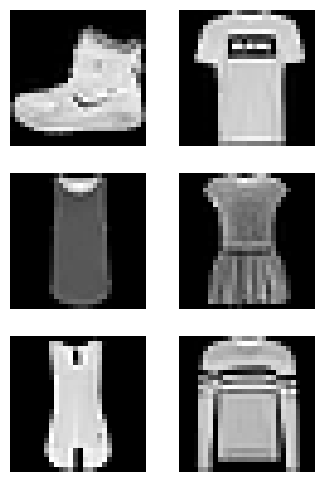

In [47]:
fig, axs = get_grid(8, nrows=3, imsize=2)
for ax,img in zip(axs.flat,imgs): show_image(img, ax)

Now that the functionality for `show_image`, `subplots` and `get_grid` has been customized, we can create a single function to handle all of these image viewing options.

In [48]:
@fc.delegates(subplots)
def show_images(
    ims: list,    # Images to show
    nrows: int|None=None, # Number of rows in a grid
    ncols: int|None=None, # Number of columns in the grid (autocalculated if None)
    titles: list|None=None, # Optional list of titles for each image
    **kwargs
):
    "Show all images `ims` as subplots with `rows` using `titles`"
    # Retrieve the second element of the output of get_grid(). Flatten the array of axes into a 1D array
    axs = get_grid(len(ims), nrows, ncols, **kwargs)[1].flat
    for im, t, ax in zip_longest(ims, titles or [], axs): show_image(im, ax=ax, title=t)

In [49]:
yb = b['label']
labels = yb[:8]

In [50]:
names = "Top Trouser Pullover Dress Coat Sandal Shirt Sneaker Bag Boot".split()
titles = itemgetter(*labels)(names)
' '.join(titles)

'Boot Top Top Dress Top Pullover Sneaker Pullover'

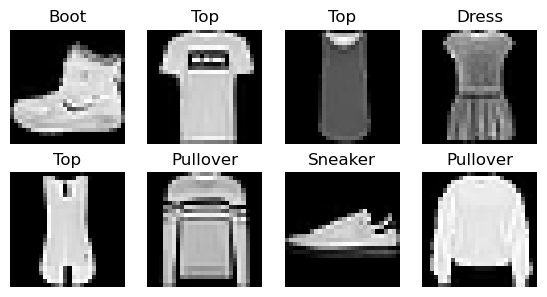

In [51]:
show_images(imgs, imsize=1.7, titles=titles)

In [52]:
class DataLoaders:
    def __init__(self, *dls): self.train, self.valid = dls[:2]

    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        f = collate_dict(dd['train'])
        return cls(*get_dls(*dd.values(), bs=batch_size, collate_fn=f, **kwargs))